# Estimating segmentation uncertainty of a convolution neural network to segment retina image

- Estimation of aleatoric and epistemic uncertainty in a DNN model for segmentation, based on the following papers (in particular, Kwon et al. 2018):
  - Gal and Ghahramani (2016) Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning  
  https://arxiv.org/pdf/1506.02142.pdf
  - Kendall and Gal (2017), What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?  
  https://arxiv.org/pdf/1703.04977.pdf
  - Kwon, Won, Kim and Paik (2018), Uncertainty quantification using Bayesian neural networks in classification  
  https://openreview.net/pdf?id=Sk_P2Q9sG


- Trains a modified UNet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004] to segment retinal images:
  - J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


## Approach

1. Train a UNet as usual, but with Dropout
2. At inference time, run model `T` times while applying Dropout and save individual predictions in array `p_hat` (`shape=(T, height, width, channels)`)
    ```
    x = Dropout(rate=0.25)(x, training=True) 
    ```
See https://github.com/keras-team/keras/issues/9412#issuecomment-366487249
3. Then, compute the mean prediction and the aleatoric and epistemic uncertainties as:
    ```
    prediction = np.mean(p_hat, axis=0)
    aleatoric  = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic  = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    ```

# Imports

In [159]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [160]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [161]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/Users/wdeback/anaconda/envs/py36/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [162]:
# load training annotations
fns = sorted(glob.glob('../data/DRIVE/training/labels/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('../data/DRIVE/test/labels/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension

**Preprocessing**

- Convert to float32
- Rescale to 0-1 interval

In [163]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)

y_train = preprocess(y_train)
y_test = preprocess(y_test)


min: 0.0, max: 1.0, shape: (31, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (31, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 1), type: float32


**Data augmentation**

- Generate a large collection of small image/segmentation snippets

In [204]:
def random_snippet(x, y, size=(48,48), rotate=True, flip=True):
    '''sample snippets from images. return image tuple (real, segmentation) of size `size` '''
    
    assert x.shape[:2] == y.shape[:2]
    
    # get image sample
    sample = np.random.randint(0, x.shape[0])
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[sample, min_h:max_h, min_w:max_w, :]
    im_y = y[sample, min_h:max_h, min_w:max_w, :]
    
    # rotate
    if rotate:
        k = np.random.randint(0,4)
        im_x = np.rot90(im_x, k=k, axes=(0,1))
        im_y = np.rot90(im_y, k=k, axes=(0,1))
        
    # flip left-right, up-down
    if flip:
        if np.random.random() < 0.5:
            lr_ud = np.random.randint(0,2) # flip up-down or left-right?
            im_x = np.flip(im_x, axis=lr_ud)
            im_y = np.flip(im_y, axis=lr_ud)
            
    
    
    return (im_x, im_y)

def get_random_snippets(x, y, number, size):
    snippets = [random_snippet(x, y, size) for i in range(number) ]
     
    ims_x = np.array([i[0] for i in snippets])
    ims_y = np.array([i[1] for i in snippets])
    return (ims_x, ims_y)

In [207]:
X_train, Y_train = get_random_snippets(x_train, y_train, number=1000, size=(96,96))
X_test, Y_test = get_random_snippets(x_train, y_train, number=100, size=(96,96))

print(X_train.shape)
print(Y_train.shape)


(1000, 96, 96, 3)
(1000, 96, 96, 1)


**Plot random snippet**

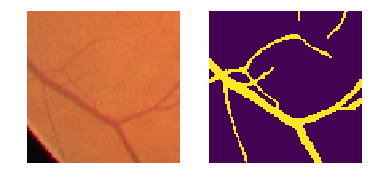

In [208]:
n = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[n])
ax[1].imshow(np.squeeze(Y_train[n]))
for a in ax: a.axis('off')


# Define a convolutional neural network

In [209]:
def UNet():
    '''U net architecture (down/up sampling with skip architecture)
    '''
    from keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding='same', 
                   kernel_initializer='glorot_normal',
                   activation='elu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout!
        return x

    inputs = Input((None, None, 3))
    
    layer1 = Conv2DReluBatchNorm(32,  (5, 5), (1,1), inputs)
    layer2 = Conv2DReluBatchNorm(64,  (5, 5), (2,2), layer1)
    layer3 = Conv2DReluBatchNorm(128, (3, 3), (2,2), layer2)
    layer4 = Conv2DReluBatchNorm(256, (3, 3), (2,2), layer3)
    layer5 = Conv2DReluBatchNorm(512, (3, 3), (2,2), layer4)

    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge6)
    
    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(32, (3, 3), (1,1), merge9)

    output    = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid', name='output')(layer9)    

    from keras.models import Model
    return Model(inputs=inputs, outputs=output)




__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

As a loss function, we'll use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [210]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    """
    A statistic used for comparing the similarity of two samples. Here binary segmentations.

    Args:
        y_true (numpy.array): the true segmentation
        y_pred (numpy.array): the predicted segmentation

    Returns:
        (float) returns a number from 0. to 1. measuring the similarity y_true and y_pred
    """
    y_true_f=K.flatten(y_true)
    mu     = y_pred[:,:,:,0]
    y_pred_f=K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))  

def precision_smooth(y_true, y_pred):
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))  

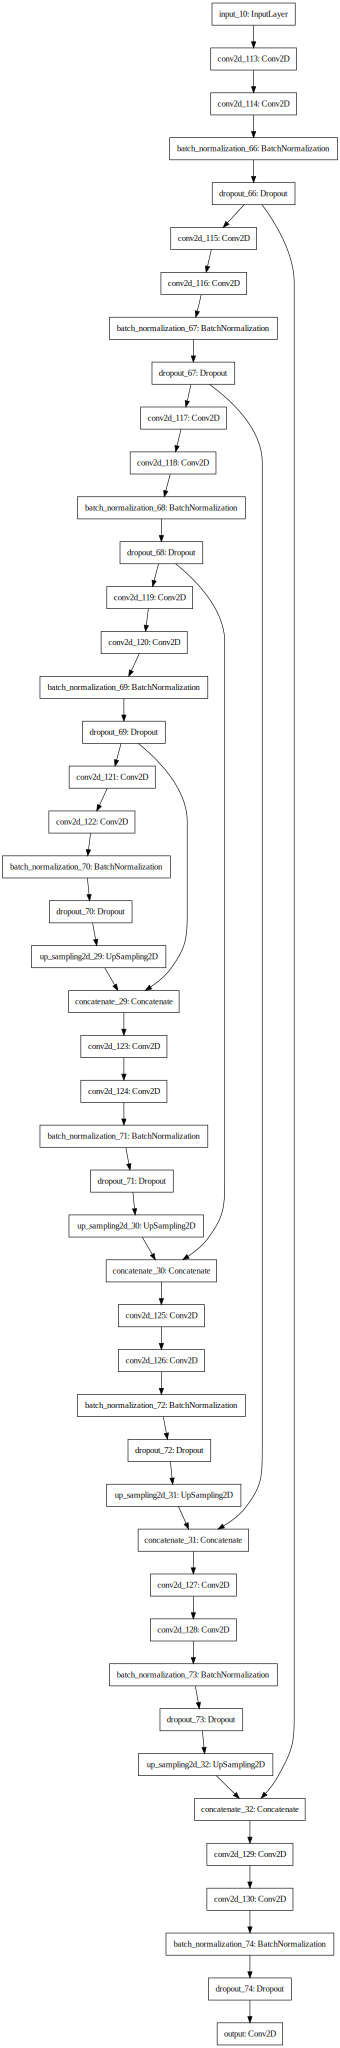

In [235]:
model = UNet()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, rankdir='TB').create(prog='dot', format='svg'))


In [214]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, precision_smooth, recall_smooth])
print("Number of parameters: ", model.count_params())

Number of parameters:  4452097


# Train the neural network

In [218]:
batch_size = 4
epochs = 10

In [219]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_data=(X_test, Y_test))


Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 326s 326ms/step - loss: 0.6154 - dice_coefficient: 0.3846 - precision_smooth: 0.2980 - recall_smooth: 0.6718 - val_loss: 0.5301 - val_dice_coefficient: 0.4699 - val_precision_smooth: 0.7567 - val_recall_smooth: 0.3537
Epoch 2/10
1000/1000 [==============================] - 269s 269ms/step - loss: 0.3333 - dice_coefficient: 0.6667 - precision_smooth: 0.6713 - recall_smooth: 0.6802 - val_loss: 0.3951 - val_dice_coefficient: 0.6049 - val_precision_smooth: 0.8072 - val_recall_smooth: 0.5083
Epoch 3/10
1000/1000 [==============================] - 313s 313ms/step - loss: 0.2791 - dice_coefficient: 0.7209 - precision_smooth: 0.7363 - recall_smooth: 0.7179 - val_loss: 0.3658 - val_dice_coefficient: 0.6342 - val_precision_smooth: 0.8427 - val_recall_smooth: 0.5243
Epoch 4/10
1000/1000 [==============================] - 282s 282ms/step - loss: 0.2611 - dice_coefficient: 0.7389 - precision_smoot

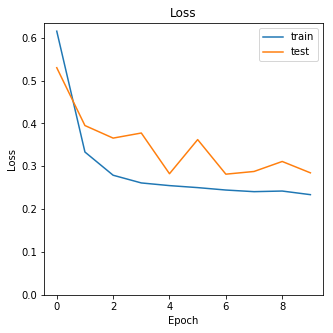

In [221]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
plot_history(history, validation=True)

In [222]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score)
#print('Test accuracy:', score[1])

100/100 [==============================] - 10s 95ms/step
Test loss: [0.25930803298950195, 0.740691967010498, 0.8220658445358277, 0.6756976175308228]


# Predict with uncertainties

In [223]:
def predict(model, image, gt, T=10):
    
    # add batch dimension
    image = np.expand_dims(image, 0)
    gt = np.expand_dims(gt, 0)
    
    # predict stochastic dropout model T times
    p_hat = []
    for t in range(T):
        p_hat.append( model.predict(image)[0] )
    p_hat = np.array(p_hat)
    
    # mean prediction
    prediction = np.mean(p_hat, axis=0)
    # threshold mean prediction
    #prediction = np.where(prediction > 0.5, 1, 0)
    
    # estimate uncertainties (eq. 4 )
    # eq.4 in https://openreview.net/pdf?id=Sk_P2Q9sG
    # see https://github.com/ykwon0407/UQ_BNN/issues/1
    aleatoric = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    
    loss, dice, precision, recall = model.evaluate(image, gt, batch_size=1)

    return np.squeeze(prediction), np.squeeze(aleatoric), np.squeeze(epistemic), (dice, precision, recall)

# Predict unseen examples

In [237]:
# generate larger images to test
X_predict, Y_predict = get_random_snippets(x_test, y_test, number=100, size=(128,128))

1/1 [==============================] - 0s 205ms/step


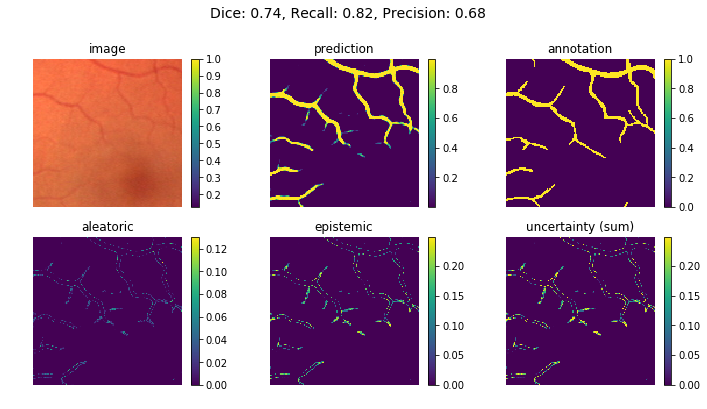

1/1 [==============================] - 0s 149ms/step


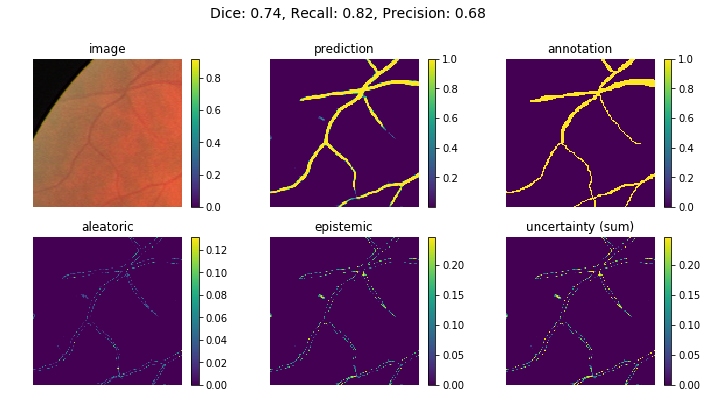

1/1 [==============================] - 0s 154ms/step


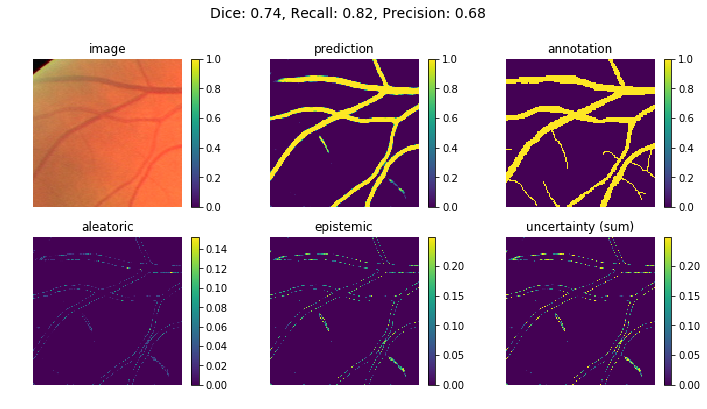

1/1 [==============================] - 0s 152ms/step


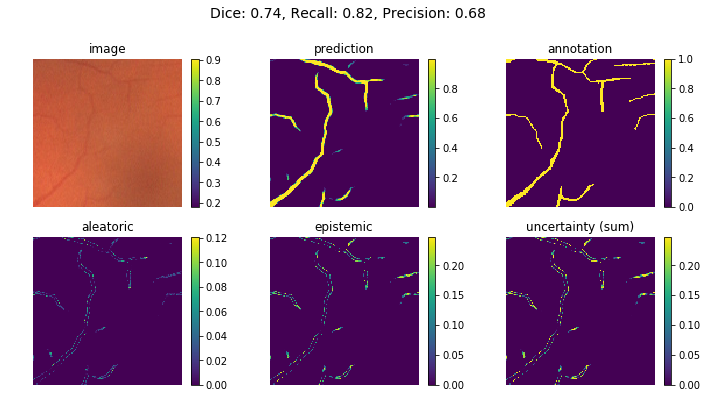

1/1 [==============================] - 0s 149ms/step


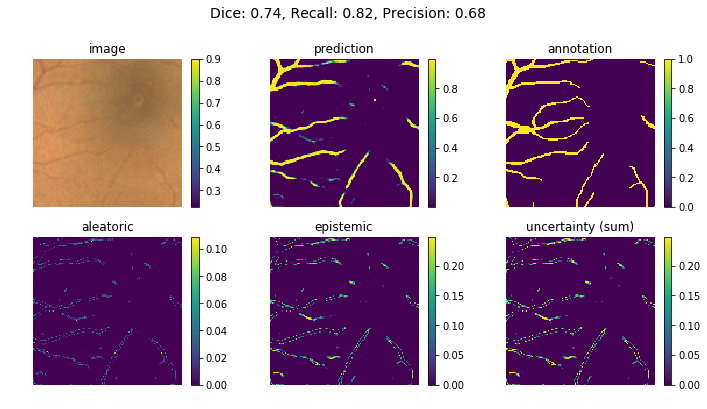

1/1 [==============================] - 0s 149ms/step


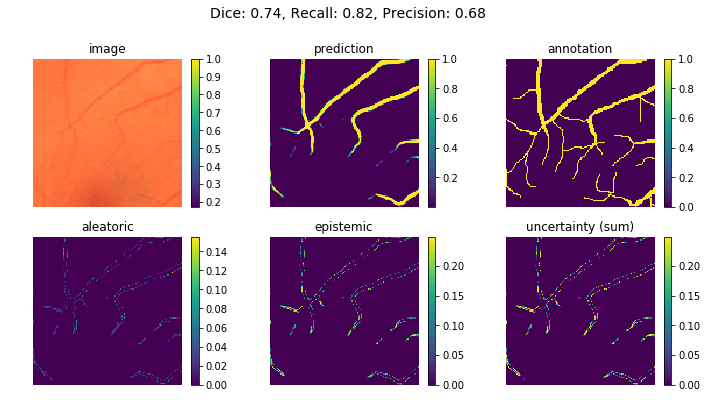

1/1 [==============================] - 0s 187ms/step


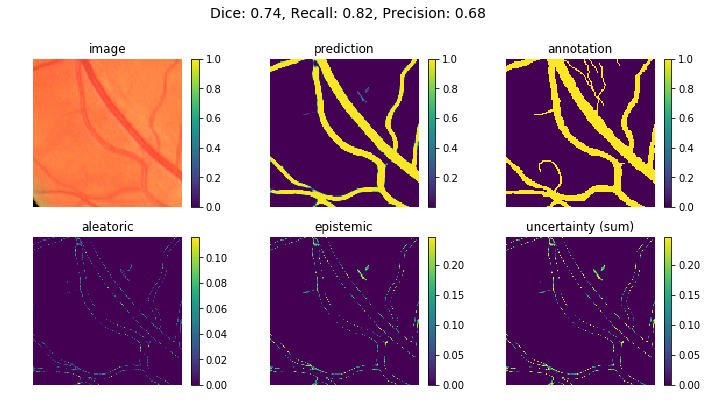

1/1 [==============================] - 0s 150ms/step


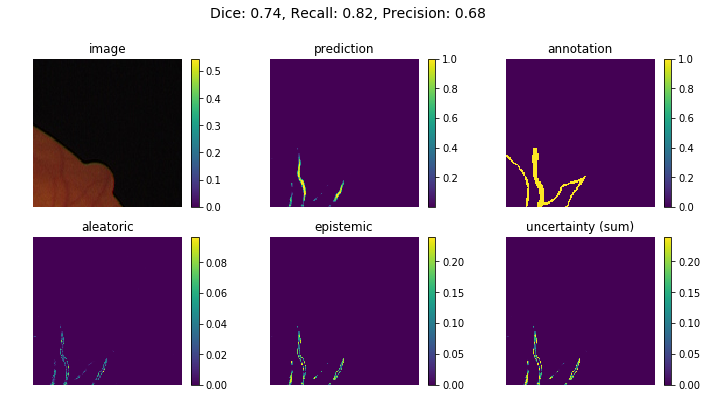

1/1 [==============================] - 0s 153ms/step


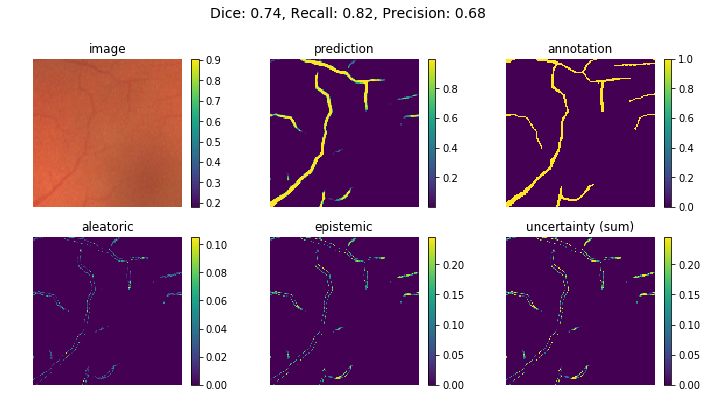

1/1 [==============================] - 0s 161ms/step


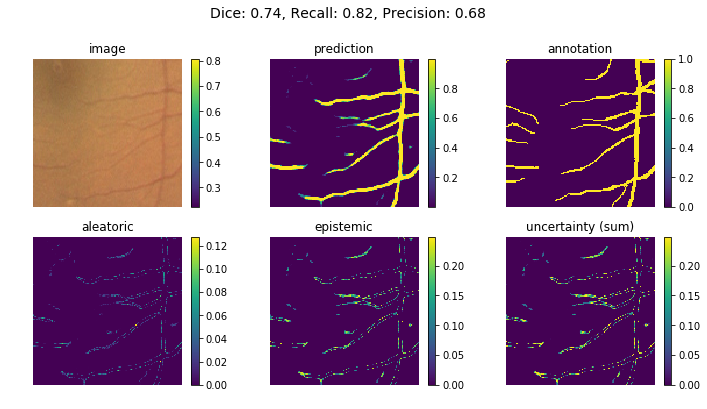

Exec time per prediction = 3.822


In [233]:
num = 10
import time
start = time.time()

for i in range(num):
    sample = np.random.randint(0,len(X_predict))
    image = X_predict[sample]
    gt    = Y_predict[sample]
    
    prediction, aleatoric, epistemic, scores = predict(model, image, gt, T=10)
    gt    = np.squeeze(gt)
        
    n = np.random.randint(0,num)
    fig, ax = plt.subplots(2,3,figsize=(12,6))
    
    _, dice, recall, precision = score
    fig.suptitle('Dice: {:.2f}, Recall: {:.2f}, Precision: {:.2f}\n'.format(dice, recall, precision), y=1.0, fontsize=14)
    
    cax0 = ax[0,0].imshow(image)
    plt.colorbar(cax0, ax=ax[0,0])
    ax[0,0].set_title('image')

    cax1 = ax[0,1].imshow(prediction)
    plt.colorbar(cax1, ax=ax[0,1])
    ax[0,1].set_title('prediction')

    cax2 = ax[0,2].imshow(gt)
    plt.colorbar(cax2, ax=ax[0,2])
    ax[0,2].set_title('annotation')
    
    cax3 = ax[1,0].imshow(aleatoric)
    plt.colorbar(cax3, ax=ax[1,0])
    ax[1,0].set_title('aleatoric')
    
    cax4 = ax[1,1].imshow(epistemic)
    plt.colorbar(cax4, ax=ax[1,1])
    ax[1,1].set_title('epistemic')

    cax5 = ax[1,2].imshow(aleatoric+epistemic)
    plt.colorbar(cax4, ax=ax[1,2])
    ax[1,2].set_title('uncertainty (sum)')

    for a in ax.flatten(): a.axis('off')
        
    fig.savefig('prediction_uncertainty_{:03d}.png'.format(i), dpi=300)
    
    plt.show()
    plt.close()

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))